# Quantum Simulation of the Schrödinger Equation Using Multi-Product Formula

We explore the application of the multi-product formula for quantum simulation ([arXiv:2403.08922](https://arxiv.org/abs/2403.08922)) to simulate the time-dependent Schrödinger equation:

$$
i \frac{\partial}{\partial t} \Psi(t) = \left(- \frac{d^2}{dx^2} + V(x) \right) \Psi(t) \tag{*}
$$

on the domain $[0, 1]$ with a smooth periodic potential function $V(x)$. We consider a discretization of the Schrödinger equation using a finite difference method with $ N $ evenly spaced nodes $
x_j = \frac{j}{N}$ for $0 \leq j \leq N-1$ and impose periodic boundary conditions. This allows us to write (*) as
$$
i \frac{\partial}{\partial t} \Psi(t) = (L + V) \Psi(t)
$$
Here we have defined the Laplace matrix $L$ and the potential matrix $V$ as follows:

$$
L = N^2
\begin{pmatrix}
2 & -1 &        &        &        & -1 \\
-1 & 2  & -1     &        &        &     \\
   & -1 & 2      & \ddots &        &     \\
   &    & \ddots & \ddots & -1     &     \\
   &    &        & -1     & 2      & -1 \\
-1 &    &        &        & -1     & 2
\end{pmatrix}
\quad \quad \quad \quad
V = 
\begin{pmatrix}
V_0 & 0   & \cdots & 0 \\
0   & V_1 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & V_{N-1}
\end{pmatrix}
$$

It is clear that $\|L\| = \mathcal{O}(N^2)$ and $\|V\| = \mathcal{O}(1)$. In this notebook, we numerically evaluate spectral norm of higher-nested commutators
$$
C_k = [X_1, [X_2, [ \cdots, [X_{k-1}, X_k] \cdots ]]]
$$
where each $X_i$ is either $L$ or $V$.

In [1]:
"""
Imports required libraries for linear algebra experiments and data visualization.
"""

import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import sympy as sp
from sympy import init_printing, latex, simplify, factor
from IPython.display import display, Math
from itertools import combinations
from scipy.stats import linregress
import pandas as pd

# Initialize pretty printing for symbolic math with LaTeX rendering
init_printing(use_latex='mathjax')

plt.rcParams.update({
    "font.size": 14,          # larger base font
    "axes.labelsize": 16,     # x/y labels
    "axes.titlesize": 16,     
    "legend.fontsize": 12,    
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "lines.linewidth": 2,
    "lines.markersize": 6,
    "figure.figsize": (6,4),  # inches, fits well in papers
    "savefig.dpi": 300,       # high resolution
})

The following list of functions provides the core tools for experimenting with linear algebra concepts related to discretized Laplace operators, potentials, commutators, and binary strings.

- `print_matrix`: LaTeX rendering of matrices  
- `generate_binary_string`: Creates randomized binary strings  
- `generate_circulant_matrix`, `laplace`: Construct Laplace matrices  
- `potential`, `smooth_potential`: Create diagonal potential matrices  
- `laplace_norm_values`, `potential_norm_values`, `ratio_values`: Compute norms and power-related values  
- `commutator`, `sympy_commutator`, `nested_commutator`, `sympy_nested_commutator`: Compute (nested) commutators  
- `all_bitstrings_by_ones`: Generates all binary strings of a given length, grouped by the number of ones, useful for systematically exploring nested commutator patterns
- `generate_permuted_bitstrings`: Generates two bitstrings of specified middle length with fixed patterns: one starting with `10` and ending with `10`, and another starting with `01` and ending with `10`. The middle part is a random sequence of zeros and ones. Used to test nested commutators with structured permutations.

In [2]:
def print_matrix(array):
    """
    Display a numpy array or nested list as a LaTeX formatted matrix.
    
    Parameters:
        array (array-like): 2D array or list representing the matrix.
    """
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{number}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))          


def generate_binary_string(a, b):
    """
    Generate a random binary string of length 'a' with exactly 'b' ones.
    
    Parameters:
        a (int): Length of the binary string.
        b (int): Number of ones in the string.
    
    Returns:
        str: Random binary string with 'b' ones and 'a-b' zeros.
        
    Raises:
        ValueError: If 'b' is not between 0 and 'a'.
    """
    if b > a or b < 0:
        raise ValueError("Number of 1's (b) must be between 0 and the length (a)")
    
    bits = ['1'] * b + ['0'] * (a - b)
    random.shuffle(bits)
    return ''.join(bits)


def Ns(min_val, max_val):
    """
    Generate a list of integers from min_val to max_val (inclusive).
    """
    return list(range(min_val, max_val + 1))


def generate_circulant_matrix(n):
    """
    Generate an n x n circulant matrix representing a discretized Laplace operator.
    """
    first_col = np.concatenate(([-2, 1], np.zeros(n - 3), [1]))
    first_row = np.roll(first_col[::-1], 1)
    return toeplitz(first_col, first_row)


def laplace(n):
    """
    Generate the scaled Laplace matrix of size n.
    
    Returns:
        ndarray: n x n Laplace matrix scaled by n^2.
    """
    return n**2 * generate_circulant_matrix(n)


def random_list(n, m):
    """
    Generate a list of n random integers in the range [1, m].
    """
    return np.random.choice(np.arange(1, m + 1), size=n, replace=True)


def potential(n, m):
    """
    Construct an n x n diagonal matrix with random integers on the diagonal.
    """
    diag_values = random_list(n, m)
    return np.diag(diag_values)


def smooth_potential(n):
    """
    Construct an n x n diagonal matrix with smoothly varying values from sin(2πx).
    """
    x = np.linspace(0, 1-(1/n), n)
    v = np.sin(2 * np.pi * x)
    return np.diag(v)


def power_values(min_val, max_val, k):
    """
    Generate list of values n^k for n in [min_val, max_val].
    """
    return [n**k for n in range(min_val, max_val + 1)]


def laplace_norm_values(min_val, max_val):
    """
    Compute 2-norm of Laplace matrices for n in [min_val, max_val].
    """
    return [np.linalg.norm(laplace(n), 2) for n in range(min_val, max_val + 1)]


def potential_norm_values(min_val, max_val, m):
    """
    Compute 2-norm of potential matrices for n in [min_val, max_val].
    """
    return [np.linalg.norm(potential(n, m), 2) for n in range(min_val, max_val + 1)]


def ratio_values(min_val, max_val, k):
    """
    Compute ratio of Laplace matrix norms to n^k for n in [min_val, max_val].
    """
    norms = laplace_norm_values(min_val, max_val)
    powers = power_values(min_val, max_val, k)
    return [l / p for l, p in zip(norms, powers)]


def commutator(X, Y):
    """
    Compute the commutator [X, Y] = XY - YX for numpy arrays.
    """
    return X @ Y - Y @ X


def sympy_commutator(X, Y):
    """
    Compute the commutator [X, Y] = XY - YX for sympy matrices.
    """
    return X * Y - Y * X


def nested_commutator(binary_string, A, B):
    """
    Compute nested commutator based on a binary string:
    '0' corresponds to A, '1' corresponds to B.
    
    Parameters:
        binary_string (str): String of '0' and '1' characters.
        A, B (array-like): Matrices or operators.
        
    Returns:
        Nested commutator result as a numpy array.
    """
    ops = [A if char == '0' else B for char in binary_string]
    result = ops[-1]
    for i in reversed(ops[:-1]):
        result = commutator(i, result)
    return result


def sympy_nested_commutator(binary_string, A, B):
    """
    Compute nested commutator for sympy matrices based on binary string.
    """
    ops = [A if char == '0' else B for char in binary_string]
    result = ops[-1]
    for op in reversed(ops[:-1]):
        result = sympy_commutator(op, result)
    return result

def all_bitstrings_by_ones(length):
    """
    Generate all binary strings of a given length, grouped by the number of ones.

    The function returns a list of binary strings containing all combinations 
    of zeros and ones for the specified length, ordered by increasing number of ones.

    Parameters:
    -----------
    length : int
        The length of the binary strings to generate.

    Returns:
    --------
    list of str
        List containing all binary strings of the specified length.
    """
    bitstrings = []
    for num_ones in range(length + 1):
        for indices in combinations(range(length), num_ones):
            bits = ['0'] * length
            for idx in indices:
                bits[idx] = '1'
            bitstrings.append(''.join(bits))
    return bitstrings

def generate_permuted_bitstrings(middle_length):
    """
    Generate two bitstrings with the same random middle 'middle' of length middle_length:
    - One with pattern '10_middle_10'
    - One with pattern '01_middle_10'
    
    Returns:
        (bitstring_10, bitstring_01)
    """
    middle = ''.join(np.random.choice(['0', '1'], middle_length))
    bitstring_10 = '10' + middle + '10'
    bitstring_01 = '01' + middle + '10'
    return bitstring_10, bitstring_01

The function `analyze_commutator_scaling` analyzes the scaling behavior of nested commutators constructed from discretized Laplace and potential matrices. For all binary strings of a given length, it computes the commutator norms across a range of matrix sizes, fits a power-law scaling exponent, and summarizes the results in a table. This helps explore how commutator norms grow with system size for different operator sequences.


In [3]:
def analyze_commutator_scaling(min_n, max_n, bit_len):
    """
    Analyze the spectral norm scaling of nested commutators defined by all binary strings
    of length `bit_len`, for matrix sizes ranging from `min_n` to `max_n`.

    For each binary string pattern, the function:
    - Precomputes smooth potential matrices and Laplace matrices for all n in [min_n, max_n].
    - Computes the nested commutator norm for each matrix size.
    - Performs log-log linear regression to estimate the power-law scaling exponent of the norm.
    - Collects the slopes (fitted power exponents) for all bitstrings.
    - Prints a summary table sorted by the number of ones and the bitstring.

    Parameters:
    -----------
    min_n : int
        Minimum matrix size.
    max_n : int
        Maximum matrix size.
    bit_len : int
        Length of binary strings representing nested commutator patterns.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns "Bitstring", "Fitted Power α", and "Num Ones", summarizing
        the scaling exponents of the commutator norms.
    """

    # Precompute matrices for all n
    A_matrices = {n: smooth_potential(n) for n in range(min_n, max_n + 1)}
    B_matrices = {n: laplace(n) for n in range(min_n, max_n + 1)}
    n_vals = list(range(min_n, max_n + 1))

    # Generate all bitstrings of given length
    bitstrings = all_bitstrings_by_ones(bit_len)

    results = []

    for binary_str in bitstrings:
        comm_norms = []

        for n in n_vals:
            A = A_matrices[n]
            B = B_matrices[n]
            comm = nested_commutator(binary_str, A, B)
            comm_norms.append(np.linalg.norm(comm, 2))

        log_n = np.log(n_vals)
        log_comm = np.log(comm_norms)
        mask = np.isfinite(log_comm)
        if np.count_nonzero(mask) < 2:
            #print(f"Skipping bitstring {binary_str}: insufficient non-zero points.")
            results.append((binary_str, np.nan))
            continue

        slope, intercept, r_value, _, _ = linregress(log_n[mask], log_comm[mask])
        results.append((binary_str, slope))

    df_results = pd.DataFrame(results, columns=["Bitstring", "Fitted Power α"])
    df_results['Num Ones'] = df_results['Bitstring'].apply(lambda x: x.count('1'))
    df_results = df_results.sort_values(['Num Ones', 'Bitstring']).reset_index(drop=True)
    df_results['Fitted Power α'] = df_results['Fitted Power α'].fillna("Commutator = 0")

    print("\nSummary of Fitted Power Exponents:")
    print(df_results.to_string(index=False))

    return df_results


Summary of Fitted Power Exponents:
Bitstring Fitted Power α  Num Ones
  0000000 Commutator = 0         0
  0000001      -3.484133         1
  0000010      -3.484133         1
  0000100 Commutator = 0         1
  0001000 Commutator = 0         1
  0010000 Commutator = 0         1
  0100000 Commutator = 0         1
  1000000 Commutator = 0         1
  0000011 Commutator = 0         2
  0000101       -1.68665         2
  0000110       -1.68665         2
  0001001       -1.68665         2
  0001010       -1.68665         2
  0001100 Commutator = 0         2
  0010001      -1.707417         2
  0010010      -1.707417         2
  0010100 Commutator = 0         2
  0011000 Commutator = 0         2
  0100001      -1.747937         2
  0100010      -1.747937         2
  0100100 Commutator = 0         2
  0101000 Commutator = 0         2
  0110000 Commutator = 0         2
  1000001       -1.50763         2
  1000010       -1.50763         2
  1000100 Commutator = 0         2
  1001000 Commutato

/var/folders/w9/vt6qqv1x2_z4929129qm9h_80000gn/T/ipykernel_4475/4168213498.py:49: RuntimeWarning: divide by zero encountered in log
  log_comm = np.log(comm_norms)


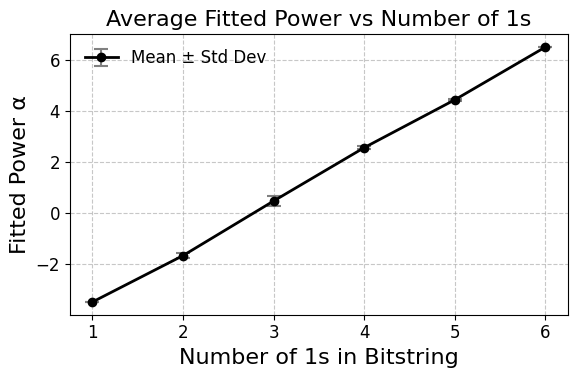

In [4]:
min_n = 10
max_n = 20

bit_len = 7

df_results = analyze_commutator_scaling(min_n, max_n, bit_len)

# Convert Fitted Power column to numeric for analysis
df_results['Slope'] = pd.to_numeric(df_results['Fitted Power α'], errors='coerce')

# Group by number of 1s to get mean and std
grouped = df_results.groupby('Num Ones')['Slope'].agg(['mean', 'std']).reset_index()

# Plot with error bars
plt.figure()
plt.errorbar(
    grouped["Num Ones"], grouped["mean"], yerr=grouped["std"],
    fmt='o-', color="black", ecolor="gray", elinewidth=1.5,
    capsize=5, capthick=1.5, label="Mean ± Std Dev"
)

plt.title("Average Fitted Power vs Number of 1s")
plt.xlabel("Number of 1s in Bitstring")
plt.ylabel("Fitted Power α")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("fitted_power.pdf")  # vector format
plt.show()

The numerical results computed in the table above suggest that the worst-case spectral norm of a length $k$ commutator of $N$ matrices scales as $\mathcal{O}(k \, N^k)$, where $k$ is the number of times the matrix $L$ appears in the nested commutator. This scaling is observed to be tight in the case when the nested commutator is
$$
\operatorname{ad}_L^k(V) = [\underbrace{L, [L, \dots, [L}_{k-\text{times}}, V]]].
$$
On the other hand, the numerical results also indicate that the actual bound on the spectral norm could be $o(k \, N^k)$. This is especially seen if $\operatorname{ad}_L^k(V)$ is padded by additional factors of $V$ to the left of the $j$-th $L$, which causes the spectral norm of the commutator to decrease. The cells below numerically test these claims in the large $N$ limit. We first define a function.

In [5]:
def compute_normalized_commutator_norms(A_func, B_func, ns, binary_str):
    """
    Computes normalized spectral norms of nested commutators
    and prints them in formatted style.
    """
    count_ones = binary_str.count('1')
    l = len(binary_str)
    results = []

    for n in ns:
        A = A_func(n)
        B = B_func(n)
        comm = nested_commutator(binary_str, A, B)
        norm_val = np.linalg.norm(comm, 2) / (count_ones * n ** count_ones)
        results.append(norm_val)

    # Print in requested format
    print(f"Results for l = {l-4}, binary string = {binary_str}:")
    print(", ".join(f"{val:.10f}" for val in results))
    print("\n")

    return results

We first test for $\operatorname{ad}_L^3(V)$ for $N = 50, 100, 500, 1000$, and show that the ratio of the spectral norm $\|\operatorname{ad}_L^3(V)\|$ to $3 N^3$ is asymptotically constant. This corresponds to row one in `Table 2` of our paper. We now test for the nested commutator $[V, \cdots, V, \operatorname{ad}_L^3(V)]$, where $V$ appears $l$ times, for $N = 50, 100, 500, 1000$, and show that the ratio of the spectral norm $\|\operatorname{ad}_L^3(V)\|$ to $3 N^3$ is asymptotically zero. This corresponds to row two ($l=5$) and row three ($l=10$) in `Table 2` of our paper.

Results for l = 0, binary string = 1110:
626.4415567649, 643.7140363857, 649.5779153082, 652.5299882306, 654.3076984658, 655.4955384878, 656.3453197595, 656.9833804997, 657.4800797582, 657.8777100760


Results for l = 5, binary string = 000001110:
0.0315617329, 0.0011036987, 0.0001509572, 0.0000365109, 0.0000121015, 0.0000049006, 0.0000022797, 0.0000011741, 0.0000006536, 0.0000003869


Results for l = 10, binary string = 00000000001110:
0.0000068993, 0.0000000078, 0.0000000001, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000




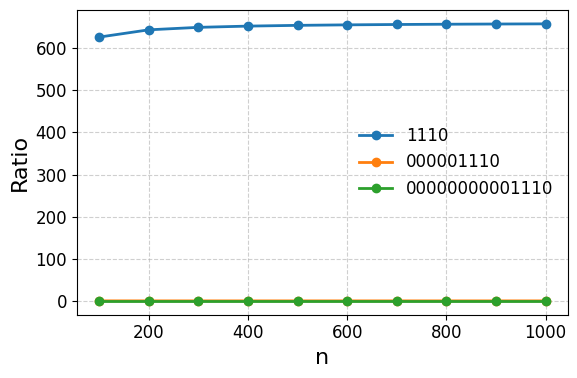

In [6]:
# List of n values to test
ns = list(range(100, 1001, 100))

# Example binary string for nested commutator
binary_stra = '1110'
binary_strb = '000001110'
binary_strc = '00000000001110'
binary_strings = [binary_stra, binary_strb, binary_strc]

# Call the function with matrix generating functions and inputs
#compute_normalized_commutator_norms(smooth_potential, laplace, ns, binary_stra)

# Run for all strings and collect
results = {}
for s in binary_strings:
    results[s] = compute_normalized_commutator_norms(smooth_potential, laplace, ns, s)

# Plot all on one figure
plt.figure()
for s, vals in results.items():
    plt.plot(ns, vals, marker='o', label=f"{s}")

plt.xlabel("n")
plt.ylabel("Ratio")
#plt.title("Normalized commutator norms for different bitstrings")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("commutator_norms.pdf")  # high-quality vector output
plt.show()

We also argue in Proposition 14 of our paper that the Frobenius norm of $C_k$ is permutation invariant. It suffices to argue that the following equality is true:

$$
\left\| [L, [V, [X_{s_3} , \dots, [X_{s_{j-1}}, [L, V]]]]] \right\|_F 
= \Theta \left( \left\| [V, [L, [X_{s_3} , \dots, [X_{s_{j-1}}, [L, V]]]]] \right\|_F \right).
$$

This is demonstrated numerically below.

1010 0110
Ratio of Frobenius norms for various values of $N$
n=100: ratio = 1.0000000000
n=200: ratio = 1.0000000000
n=300: ratio = 1.0000000000
n=400: ratio = 1.0000000000
n=500: ratio = 1.0000000000
n=600: ratio = 1.0000000000
n=700: ratio = 1.0000000000
n=800: ratio = 1.0000000000
n=900: ratio = 1.0000000000
n=1000: ratio = 1.0000000000


100101010 010101010
Ratio of Frobenius norms for various values of $N$
n=100: ratio = 1.0081812732
n=200: ratio = 1.0079583854
n=300: ratio = 1.0079171722
n=400: ratio = 1.0079027521
n=500: ratio = 1.0078960785
n=600: ratio = 1.0078924536
n=700: ratio = 1.0078902679
n=800: ratio = 1.0078888494
n=900: ratio = 1.0078878768
n=1000: ratio = 1.0078871812


10011001010010 01011001010010
Ratio of Frobenius norms for various values of $N$
n=100: ratio = 0.9881926551
n=200: ratio = 0.9881334246
n=300: ratio = 0.9881225050
n=400: ratio = 0.9881186868
n=500: ratio = 0.9881169201
n=600: ratio = 0.9881159605
n=700: ratio = 0.9881153808
n=800: ratio = 0.98811499

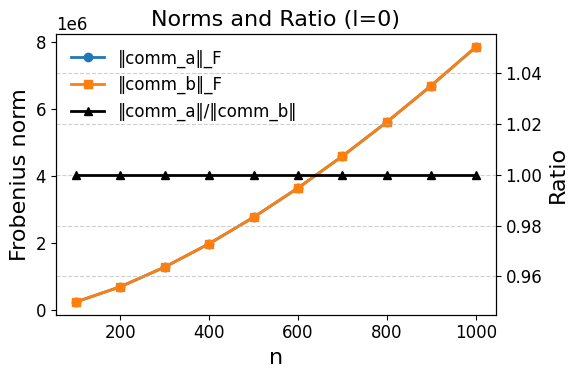

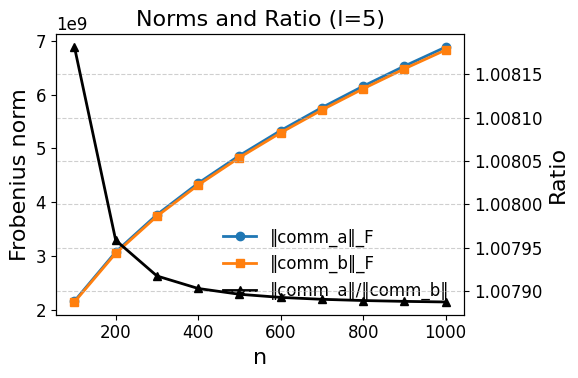

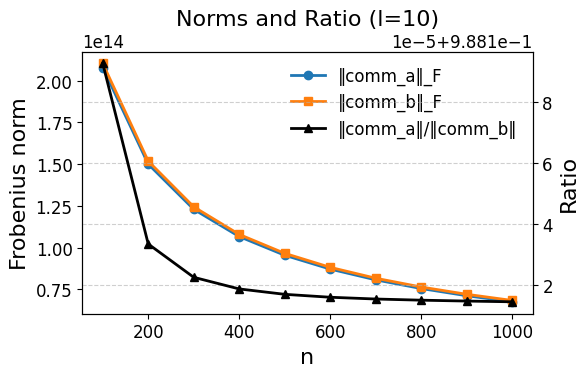

In [7]:
def test_frobenius_ratios(smooth_potential, laplace, ns, middle_lengths):
    """
    For each middle length, generate two bitstrings with patterns '10...10' and '01...10',
    then compute normalized Frobenius norm ratios of nested commutators for different n.
    """

    results = {}

    for l in middle_lengths:
        # Generate both patterns
        [bitstring_10, bitstring_01] = generate_permuted_bitstrings(l)

        print(bitstring_10, bitstring_01)

        norms_a = []
        norms_b = []
        ratios = []

        print("Ratio of Frobenius norms for various values of $N$")

        for n in ns:
            A = smooth_potential(n)
            B = laplace(n)
            comm_a = nested_commutator(bitstring_10, A, B)
            comm_b = nested_commutator(bitstring_01, A, B)

            norm_a = np.linalg.norm(comm_a, 'fro')
            norm_b = np.linalg.norm(comm_b, 'fro')
            ratio = norm_a / norm_b

            norms_a.append(norm_a)
            norms_b.append(norm_b)
            ratios.append(ratio)
            
            ratio = norm_a/norm_b
            print(f"n={n}: ratio = {ratio:.10f}")
        
        print("\n")

        results[l] = {
            "norms_a": norms_a,
            "norms_b": norms_b,
            "ratios": ratios,
        }

    return results

ns = list(range(100, 1001, 100))
middle_lengths = [0, 5, 10]
#test_frobenius_ratios(smooth_potential, laplace, ns, middle_lengths)
results = test_frobenius_ratios(smooth_potential, laplace, ns, middle_lengths)

# Plot norms and ratios outside
for l in middle_lengths:
    data = results[l]

    fig, ax1 = plt.subplots(figsize=(6,4))

    # left y-axis: norms
    ax1.plot(ns, data["norms_a"], marker='o', label='‖comm_a‖_F')
    ax1.plot(ns, data["norms_b"], marker='s', label='‖comm_b‖_F')
    ax1.set_xlabel("n")
    ax1.set_ylabel("Frobenius norm")
    ax1.tick_params(axis='y')

    # right y-axis: ratio
    ax2 = ax1.twinx()
    ax2.plot(ns, data["ratios"], marker='^', color='black', label='‖comm_a‖/‖comm_b‖')
    ax2.set_ylabel("Ratio")
    ax2.tick_params(axis='y')

    # combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best", frameon=False)

    plt.title(f"Norms and Ratio (l={l})")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    #plt.savefig(f"norms_ratio_l{l}.pdf")  # vector format
    plt.show()

We found using symbolic computations helpful to understand the structure of the nested commutators. The following code block can be used for such computations.

In [32]:
n = 8
B = laplace(n)

def symbolic_diagonal_matrix(n):
    V = sp.symbols(f'V_0:{n}')
    return sp.diag(*V)

V_sym = symbolic_diagonal_matrix(n)
L_sym = sp.Matrix((B/n**2).astype(int))

stra='1110'
strb='111110'

m1 = sympy_nested_commutator(stra, V_sym, L_sym)
m2 = sympy_nested_commutator(strb, V_sym, L_sym)

In [33]:
m1

⎡            0              -9⋅V₀ + 9⋅V₁ - 3⋅V₂ + 3⋅V₇              0          ↪
⎢                                                                              ↪
⎢9⋅V₀ - 9⋅V₁ + 3⋅V₂ - 3⋅V₇              0               3⋅V₀ - 9⋅V₁ + 9⋅V₂ - 3 ↪
⎢                                                                              ↪
⎢            0              -3⋅V₀ + 9⋅V₁ - 9⋅V₂ + 3⋅V₃              0          ↪
⎢                                                                              ↪
⎢  V₀ - 3⋅V₁ + 3⋅V₂ - V₃                0               -3⋅V₁ + 9⋅V₂ - 9⋅V₃ +  ↪
⎢                                                                              ↪
⎢            0                V₁ - 3⋅V₂ + 3⋅V₃ - V₄                 0          ↪
⎢                                                                              ↪
⎢  V₀ - V₅ + 3⋅V₆ - 3⋅V₇                0                 V₂ - 3⋅V₃ + 3⋅V₄ - V ↪
⎢                                                                              ↪
⎢            0              